# Evaluation

## M5 Dataset

In [ ]:
import pandas as pd

from datasetsforecast.m5 import M5, M5Evaluation
from statsforecast import StatsForecast

### Evaluator

In [ ]:
def evaluate_forecasts(df, model, model_name):
    Y_hat = df.set_index('ds', append=True)[model].unstack()
    *_, S_df = M5.load('data')
    Y_hat = S_df.merge(Y_hat, how='left', on=['unique_id'])
    eval_ = M5Evaluation.evaluate(y_hat=Y_hat, directory='./data')
    eval_ = eval_.rename(columns={'wrmsse': f'{model_name}_{model}_wrmsse'})
    return eval_

### Read Forecasts

In [ ]:
statsforecasts_df = pd.read_parquet('s3://m5-benchmarks/forecasts/statsforecast-m5.parquet')

In [ ]:
amazonforecasts_df = pd.read_parquet('s3://m5-benchmarks/forecasts/amazonforecast-m5.parquet')
amazonforecasts_df = amazonforecasts_df.rename(columns={'item_id': 'unique_id', 'date': 'ds'})
amazonforecasts_df['unique_id'] = amazonforecasts_df['unique_id'].str.upper()
amazonforecasts_df = amazonforecasts_df.set_index('unique_id')
amazonforecasts_df['ds'] = pd.to_datetime(amazonforecasts_df['ds']).dt.tz_localize(None)

### Evaluate performances

In [ ]:
pd.concat([
    evaluate_forecasts(statsforecasts_df, 'ThETS', 'StatsForecast'),
    evaluate_forecasts(amazonforecasts_df, 'p50', 'AmazonForecast'),
    evaluate_forecasts(statsforecasts_df, 'SeasonalNaive', 'StatsForecast'),
], axis=1)

,StatsForecast_ThETS_wrmsse,AmazonForecast_p50_wrmsse,StatsForecast_SeasonalNaive_wrmsse
Total,0.669606,1.617815,0.847017
Level1,0.424331,1.912144,0.560047
Level2,0.515777,1.786991,0.673050
Level3,0.580670,1.736382,0.717606
Level4,0.474098,1.972658,0.622975
Level5,0.552459,2.010498,0.708155
Level6,0.578092,1.805926,0.759991
Level7,0.651079,1.819329,0.829187
Level8,0.642446,1.667225,0.800835
Level9,0.725324,1.619216,0.888126


### Forecasts plot

In [ ]:
forecasts_df = statsforecasts_df.merge(
    amazonforecasts_df.rename(columns={'p50': 'AmazonForecast'})[['ds', 'AmazonForecast']], 
    on=['unique_id', 'ds']
)

In [ ]:
Y_df = pd.read_parquet('s3://m5-benchmarks/data/train/target.parquet') 
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'demand': 'y'
})

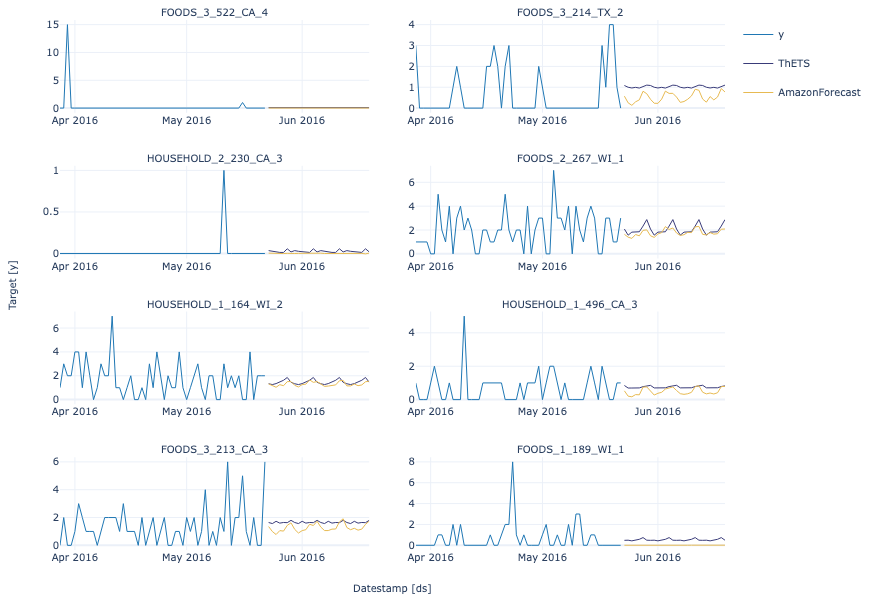

In [ ]:
StatsForecast.plot(
    Y_df, 
    forecasts_df, 
    max_insample_length=28 * 2,
    models=['ThETS', 'AmazonForecast']
)

## M4 Daily Dataset

### Evaluator

In [ ]:
from datasetsforecast.m4 import M4Evaluation

In [ ]:
def evaluate_forecasts(df, model, model_name):
    Y_hat = df.set_index('ds', append=True).sort_values(['unique_id', 'ds'])[model].unstack()
    eval_ = M4Evaluation.evaluate(y_hat=Y_hat.values, directory='./data', group='Daily')
    eval_.insert(0, 'Model', f'{model_name}_{model}')
    return eval_

### Read Forecasts

In [ ]:
statsforecasts_df = pd.read_parquet('s3://m4-benchmarks/forecasts/statsforecast-m4-daily.parquet')

In [ ]:
amazonforecasts_df = pd.read_parquet('s3://m4-benchmarks/forecasts/amazonforecast-m4-daily.parquet')
amazonforecasts_df = amazonforecasts_df.rename(columns={'item_id': 'unique_id', 'date': 'ds'})
amazonforecasts_df['unique_id'] = amazonforecasts_df['unique_id'].str.upper()
amazonforecasts_df = amazonforecasts_df.set_index('unique_id')
amazonforecasts_df['ds'] = pd.to_datetime(amazonforecasts_df['ds']).dt.tz_localize(None)

### Evaluate performances

In [ ]:
pd.concat([
    evaluate_forecasts(statsforecasts_df, 'ThETS', 'StatsForecast'),
    evaluate_forecasts(amazonforecasts_df, 'mean', 'AmazonForecast'),
    evaluate_forecasts(statsforecasts_df, 'SeasonalNaive', 'StatsForecast'),
])

,Model,SMAPE,MASE,OWA
Daily,StatsForecast_ThETS,3.044642,3.455774,1.026948
Daily,AmazonForecast_mean,3.084224,3.396990,1.024482
Daily,StatsForecast_SeasonalNaive,3.741925,4.128193,1.243987


### Forecasts plot

In [ ]:
forecasts_df = statsforecasts_df.merge(
    amazonforecasts_df.rename(columns={'mean': 'AmazonForecast'})[['ds', 'AmazonForecast']], 
    on=['unique_id', 'ds']
)

In [ ]:
Y_df = pd.read_parquet('s3://m4-benchmarks/data/train/target.parquet') 
Y_df = Y_df.rename(columns={
    'item_id': 'unique_id', 
    'timestamp': 'ds', 
    'target_value': 'y'
})

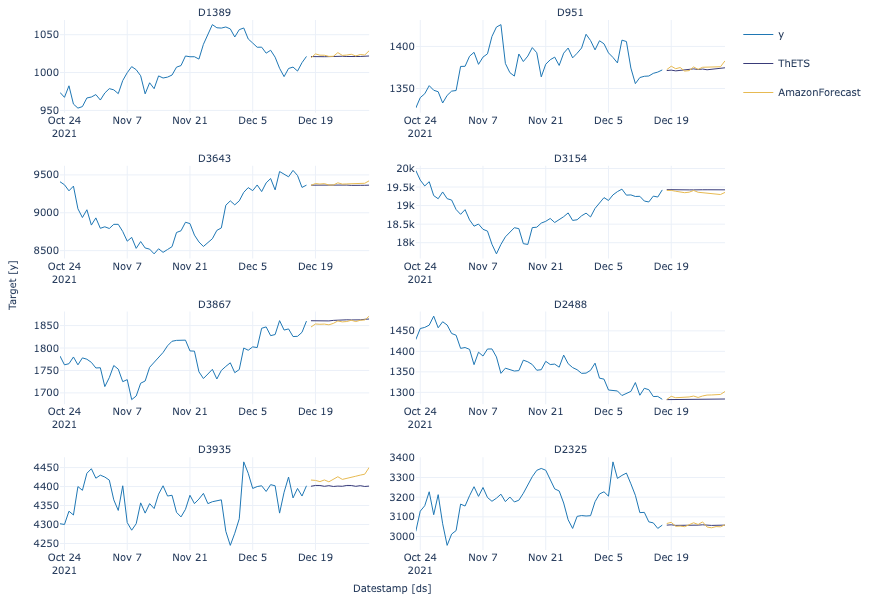

In [ ]:
StatsForecast.plot(
    Y_df, 
    forecasts_df, 
    max_insample_length=28 * 2,
    models=['ThETS', 'AmazonForecast']
)